## MIE424 (2022 Winter) Lab 4


In [1]:
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]"

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import matplotlib

Using JAX to calculate gradients
======

This part of the lab will explain how to automatically calculate gradients that can then be used in many optimiazation algorithms, such as gradient descent.

* The hope is to give you a base to be able to implement algorithms manually.
* Visualizing these concepts makes life much easier.
* Get into the habit of trying things out! Machine learning is wonderful because it is so successful.

In [13]:
key = random.PRNGKey(1)

data_points, data_dimension = 100, 2

# Generate X and w, then set y = Xw + ϵ
X = random.normal(key, (data_points, data_dimension))

true_w = random.normal(key, (data_dimension,))
y = X.dot(true_w) + 0.1 * random.normal(key, (data_points,))

def make_squared_error(X, y):
    def squared_error(w):
        return jnp.sum(jnp.power(X.dot(w) - y, 2)) / X.shape[0]
    return squared_error

# Now use jax grad
grad_loss = grad(make_squared_error(X, y))

# Basic gradient descent
w_grad = np.zeros(data_dimension)
step = 0.1
iterations = 100
for i in range(iterations):
    w_grad = w_grad - step * grad_loss(w_grad)

# Linear algebra solution
w_linalg = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)

In [14]:
print(w_grad)
print(w_linalg)

[-0.12588222  2.2070646 ]
[-0.12588218  2.207065  ]


# Finite Difference Estimation

One way to estimate the gradient at a certain point is to take the "slope" at that point with a very small step in x.
Let's check if the grad of jax is accurate and makes sense numerically using finite differences.

In [17]:
# Set a step size for finite differences calculations
eps = 1e-2
w = true_w

# Check W_grad with finite differences in a random direction
key, subkey = random.split(key)
vec = random.normal(subkey, w.shape)
unitvec = vec / jnp.sqrt(jnp.vdot(vec, vec))
w_grad_numerical = (make_squared_error(X, y)(w + eps / 2. * unitvec) - make_squared_error(X, y)(w - eps / 2. * unitvec)) / eps
print('w_grad_numerical', w_grad_numerical)
print('W_dirderiv_autodiff', jnp.vdot(grad(make_squared_error(X, y))(w), unitvec))

w_grad_numerical 0.017714314
W_dirderiv_autodiff 0.017714035


In [18]:
for eps in np.logspace(-8,0,9):
    w_grad_numerical = (make_squared_error(X, y)(w + eps / 2. * unitvec) - make_squared_error(X, y)(w - eps / 2. * unitvec)) / eps
    print(f'Epsilon used: {eps}, directional derivative with FDM:  {w_grad_numerical}, difference with autodiff: {abs(w_grad_numerical-jnp.vdot(grad(make_squared_error(X, y))(w), unitvec))}')

Epsilon used: 1e-08, directional derivative with FDM:  0.0, difference with autodiff: 0.017714034765958786
Epsilon used: 1e-07, directional derivative with FDM:  0.03725290298461914, difference with autodiff: 0.019538868218660355
Epsilon used: 1e-06, directional derivative with FDM:  0.017695128917694092, difference with autodiff: 1.8905848264694214e-05
Epsilon used: 1e-05, directional derivative with FDM:  0.017881393432617188, difference with autodiff: 0.0001673586666584015
Epsilon used: 0.0001, directional derivative with FDM:  0.017741695046424866, difference with autodiff: 2.7660280466079712e-05
Epsilon used: 0.001, directional derivative with FDM:  0.01771189272403717, difference with autodiff: 2.1420419216156006e-06
Epsilon used: 0.01, directional derivative with FDM:  0.01771431416273117, difference with autodiff: 2.7939677238464355e-07
Epsilon used: 0.1, directional derivative with FDM:  0.017714034765958786, difference with autodiff: 0.0
Epsilon used: 1.0, directional derivat

# Visualizing Gradient Descent

Now we are going to talk about visualizing each step in the gradient descent algorithm, starting with a one dimensional, and then continuing with a two dimensional data. We will be looking at how this affects both the data space (X vs Y) and the parameter space (w0 vs w1 vs Loss).

/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


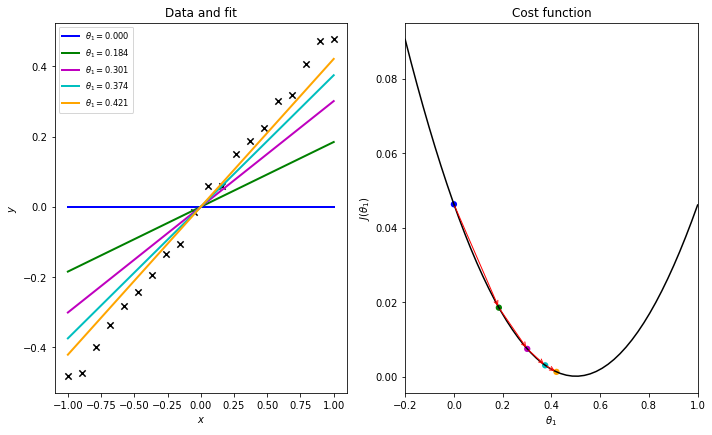

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# The data to fit
m = 20
theta1_true = 0.5
x = np.linspace(-1,1,m)
y = theta1_true * x + 0.02*np.random.randn(m)

# The plot: LHS is the data, RHS will be the cost function.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6.15))
ax[0].scatter(x, y, marker='x', s=40, color='k')

def cost_func(theta1):
    """The cost function, J(theta1) describing the goodness of fit."""
    theta1 = np.atleast_2d(np.asarray(theta1))
    return np.average((y-hypothesis(x, theta1))**2, axis=1)/2

def hypothesis(x, theta1):
    """Our "hypothesis function", a straight line through the origin."""
    return theta1*x

# First construct a grid of theta1 parameter pairs and their corresponding
# cost function values.
theta1_grid = np.linspace(-0.2,1,50)
J_grid = cost_func(theta1_grid[:,np.newaxis])

# The cost function as a function of its single parameter, theta1.
ax[1].plot(theta1_grid, J_grid, 'k')

# Take N steps with learning rate alpha down the steepest gradient,
# starting at theta1 = 0.
N = 5
alpha = 1
theta1 = [0]
J = [cost_func(theta1[0])[0]]
for j in range(N-1):
    last_theta1 = theta1[-1]
    this_theta1 = last_theta1 - alpha / m * np.sum(
                                    (hypothesis(x, last_theta1) - y) * x)
    theta1.append(this_theta1)
    J.append(cost_func(this_theta1))

# Annotate the cost function plot with coloured points indicating the
# parameters chosen and red arrows indicating the steps down the gradient.
# Also plot the fit function on the LHS data plot in a matching colour.
colors = ['b', 'g', 'm', 'c', 'orange']
ax[0].plot(x, hypothesis(x, theta1[0]), color=colors[0], lw=2,
           label=r'$\theta_1 = {:.3f}$'.format(theta1[0]))
for j in range(1,N):
    ax[1].annotate('', xy=(theta1[j], J[j]), xytext=(theta1[j-1], J[j-1]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    ax[0].plot(x, hypothesis(x, theta1[j]), color=colors[j], lw=2,
               label=r'$\theta_1 = {:.3f}$'.format(theta1[j]))

# Labels, titles and a legend.
ax[1].scatter(theta1, J, c=colors, s=40, lw=0)
ax[1].set_xlim(-0.2,1)
ax[1].set_xlabel(r'$\theta_1$')
ax[1].set_ylabel(r'$J(\theta_1)$')
ax[1].set_title('Cost function')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title('Data and fit')
ax[0].legend(loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

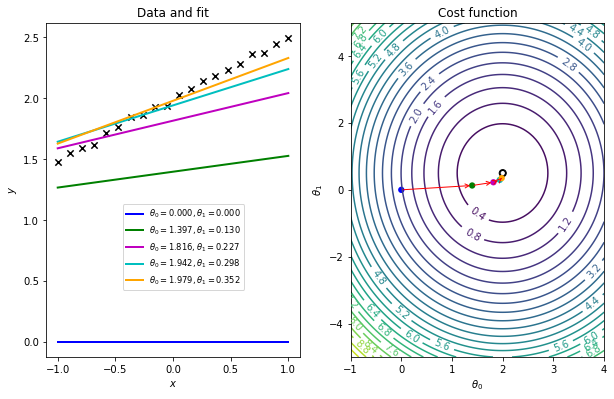

In [7]:
# The data to fit
m = 20
theta0_true = 2
theta1_true = 0.5
x = np.linspace(-1,1,m)
y = theta0_true + theta1_true * x + 0.02*np.random.randn(m)

# The plot: LHS is the data, RHS will be the cost function.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6.15))
ax[0].scatter(x, y, marker='x', s=40, color='k')

def cost_func(theta0, theta1):
    """The cost function, J(theta0, theta1) describing the goodness of fit."""
    theta0 = np.atleast_3d(np.asarray(theta0))
    theta1 = np.atleast_3d(np.asarray(theta1))
    return np.average((y-hypothesis(x, theta0, theta1))**2, axis=2)/2

def hypothesis(x, theta0, theta1):
    """Our "hypothesis function", a straight line."""
    return theta0 + theta1*x

# First construct a grid of (theta0, theta1) parameter pairs and their
# corresponding cost function values.
theta0_grid = np.linspace(-1,4,101)
theta1_grid = np.linspace(-5,5,101)
J_grid = cost_func(theta0_grid[np.newaxis,:,np.newaxis],
                   theta1_grid[:,np.newaxis,np.newaxis])

# A labeled contour plot for the RHS cost function
X, Y = np.meshgrid(theta0_grid, theta1_grid)
contours = ax[1].contour(X, Y, J_grid, 30)
ax[1].clabel(contours)
# The target parameter values indicated on the cost function contour plot
ax[1].scatter([theta0_true]*2,[theta1_true]*2,s=[50,10], color=['k','w'])

# Take N steps with learning rate alpha down the steepest gradient,
# starting at (theta0, theta1) = (0, 0).
N = 5
alpha = 0.7
theta = [np.array((0,0))]
J = [cost_func(*theta[0])[0]]
for j in range(N-1):
    last_theta = theta[-1]
    this_theta = np.empty((2,))
    this_theta[0] = last_theta[0] - alpha / m * np.sum(
                                    (hypothesis(x, *last_theta) - y))
    this_theta[1] = last_theta[1] - alpha / m * np.sum(
                                    (hypothesis(x, *last_theta) - y) * x)
    theta.append(this_theta)
    J.append(cost_func(*this_theta))


# Annotate the cost function plot with coloured points indicating the
# parameters chosen and red arrows indicating the steps down the gradient.
# Also plot the fit function on the LHS data plot in a matching colour.
colors = ['b', 'g', 'm', 'c', 'orange']
ax[0].plot(x, hypothesis(x, *theta[0]), color=colors[0], lw=2,
           label=r'$\theta_0 = {:.3f}, \theta_1 = {:.3f}$'.format(*theta[0]))
for j in range(1,N):
    ax[1].annotate('', xy=theta[j], xytext=theta[j-1],
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    ax[0].plot(x, hypothesis(x, *theta[j]), color=colors[j], lw=2,
           label=r'$\theta_0 = {:.3f}, \theta_1 = {:.3f}$'.format(*theta[j]))
ax[1].scatter(*zip(*theta), c=colors, s=40, lw=0)

# Labels, titles and a legend.
ax[1].set_xlabel(r'$\theta_0$')
ax[1].set_ylabel(r'$\theta_1$')
ax[1].set_title('Cost function')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title('Data and fit')
axbox = ax[0].get_position()
# Position the legend by hand so that it doesn't cover up any of the lines.
ax[0].legend(loc=(axbox.x0+0.5*axbox.width, axbox.y0+0.1*axbox.height),
             fontsize='small')

plt.show()

# References

Code was used from the following sources:

https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/autodiff_cookbook.ipynb#scrollTo=R8q5RiY3l7Fw

https://scipython.com/blog/visualizing-the-gradient-descent-method/

https://colindcarroll.com/2019/04/06/exercises-in-automatic-differentiation-using-autograd-and-jax/